In [1]:
import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Compose
import skimage

In [2]:
#original 512 x 512
i_width = 28
i_height = 28
input_shape = i_width*i_height

In [3]:
def AddImage(path):
  ds = dicom.dcmread(path)

  image = ds.pixel_array
  image = image.astype(np.int16)
  image[image == -2000] = 0
  
  # Convert to Hounsfield units (HU)
  intercept = ds.RescaleIntercept
  slope = ds.RescaleSlope
  
  if slope != 1:
      image = slope * image.astype(np.float64)
      image = image.astype(np.int16)
      
  image += np.int16(intercept)
  image =  np.array(image, dtype=np.float32)
  #resize for more faster nn learning
  image = skimage.transform.resize(image, (i_height, i_width))
  return image

def AddImageToArray(x,folderPath):
  patchs = os.listdir(folderPath)
  for filename in sorted(patchs, key=len):
    f = os.path.join(folderPath, filename)
    if os.path.isfile(f):
      x.append(AddImage(os.path.join(folderPath, filename)))
    else:
      AddImageToArray(x,f)

In [4]:
x_trn = []
x_tst = []

AddImageToArray(x_trn ,'DICOM\skulls\skull8')
AddImageToArray(x_tst ,'DICOM\PA5\ST1\SE4')

x_trn = np.array(x_trn, np.float32)
x_tst = np.array(x_tst, np.float32)

In [5]:
max_value = np.max(x_trn)
print(max_value)
x_trn /= max_value
x_tst /= max_value

print(len(x_trn ))
print(x_trn.shape)
print(x_trn[0].max())

1408.7592
234
(234, 28, 28)
0.15389232


In [26]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=256
        )
        self.encoder_output_layer = nn.Linear(
            in_features=256, out_features=150
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=150, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [27]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=input_shape).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-5)

# mean-squared error loss
criterion = nn.MSELoss()

In [28]:
def train(epochs, model, criterion, optimizer, train_loader):
    for epoch in range(epochs):
        loss = 0
        for batch_features in train_loader:
            # reshape mini-batch data to [N, 784] matrix
            # load it to the active device
            batch_features = batch_features.view(-1, input_shape).to(device)
            
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            
            # compute reconstructions
            outputs = model(batch_features)
            
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
        
        # compute the epoch training loss
        loss = loss / len(train_loader)
        
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    
    return model

In [29]:
transform = Compose([ToTensor()])

train_loader = torch.utils.data.DataLoader(
    x_trn, batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    x_tst, batch_size=32, shuffle=False
)

In [30]:
model = train(1000, model, criterion, optimizer, train_loader)

epoch : 1/1000, loss = 0.492155
epoch : 2/1000, loss = 0.491212
epoch : 3/1000, loss = 0.491136
epoch : 4/1000, loss = 0.490779
epoch : 5/1000, loss = 0.490203
epoch : 6/1000, loss = 0.490324
epoch : 7/1000, loss = 0.489803
epoch : 8/1000, loss = 0.489413
epoch : 9/1000, loss = 0.490227
epoch : 10/1000, loss = 0.489661
epoch : 11/1000, loss = 0.489531
epoch : 12/1000, loss = 0.489475
epoch : 13/1000, loss = 0.489367
epoch : 14/1000, loss = 0.489311
epoch : 15/1000, loss = 0.488799
epoch : 16/1000, loss = 0.489054
epoch : 17/1000, loss = 0.488743
epoch : 18/1000, loss = 0.488626
epoch : 19/1000, loss = 0.488362
epoch : 20/1000, loss = 0.488621
epoch : 21/1000, loss = 0.488319
epoch : 22/1000, loss = 0.488535
epoch : 23/1000, loss = 0.488744
epoch : 24/1000, loss = 0.488002
epoch : 25/1000, loss = 0.488073
epoch : 26/1000, loss = 0.487761
epoch : 27/1000, loss = 0.488002
epoch : 28/1000, loss = 0.488135
epoch : 29/1000, loss = 0.487679
epoch : 30/1000, loss = 0.487602
epoch : 31/1000, lo

KeyboardInterrupt: 

In [19]:
test_examples = []
with torch.no_grad():
    for batch_features in test_loader:
        test_examples = np.array(batch_features)
        batch_features = batch_features.view(-1, input_shape).to(device)
        reconstruction = model(batch_features)
        break

<Figure size 2500x2500 with 0 Axes>

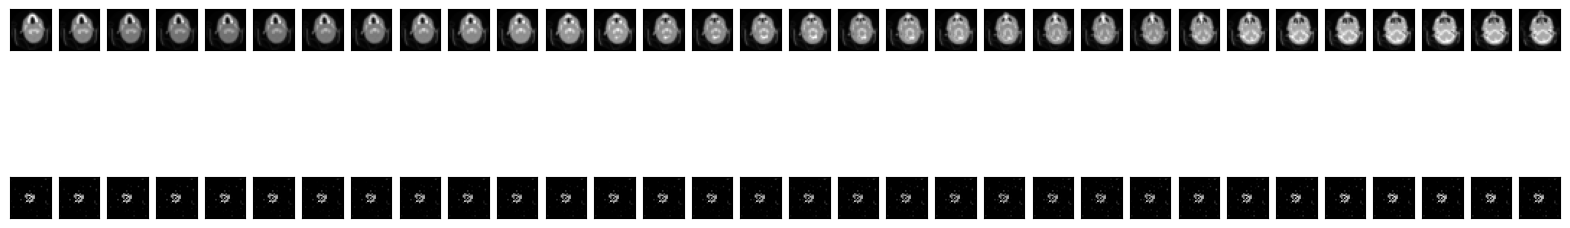

In [20]:
plt.figure(figsize=(25,25))
with torch.no_grad():
    number = 32
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].reshape(i_height, i_width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(i_height, i_width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

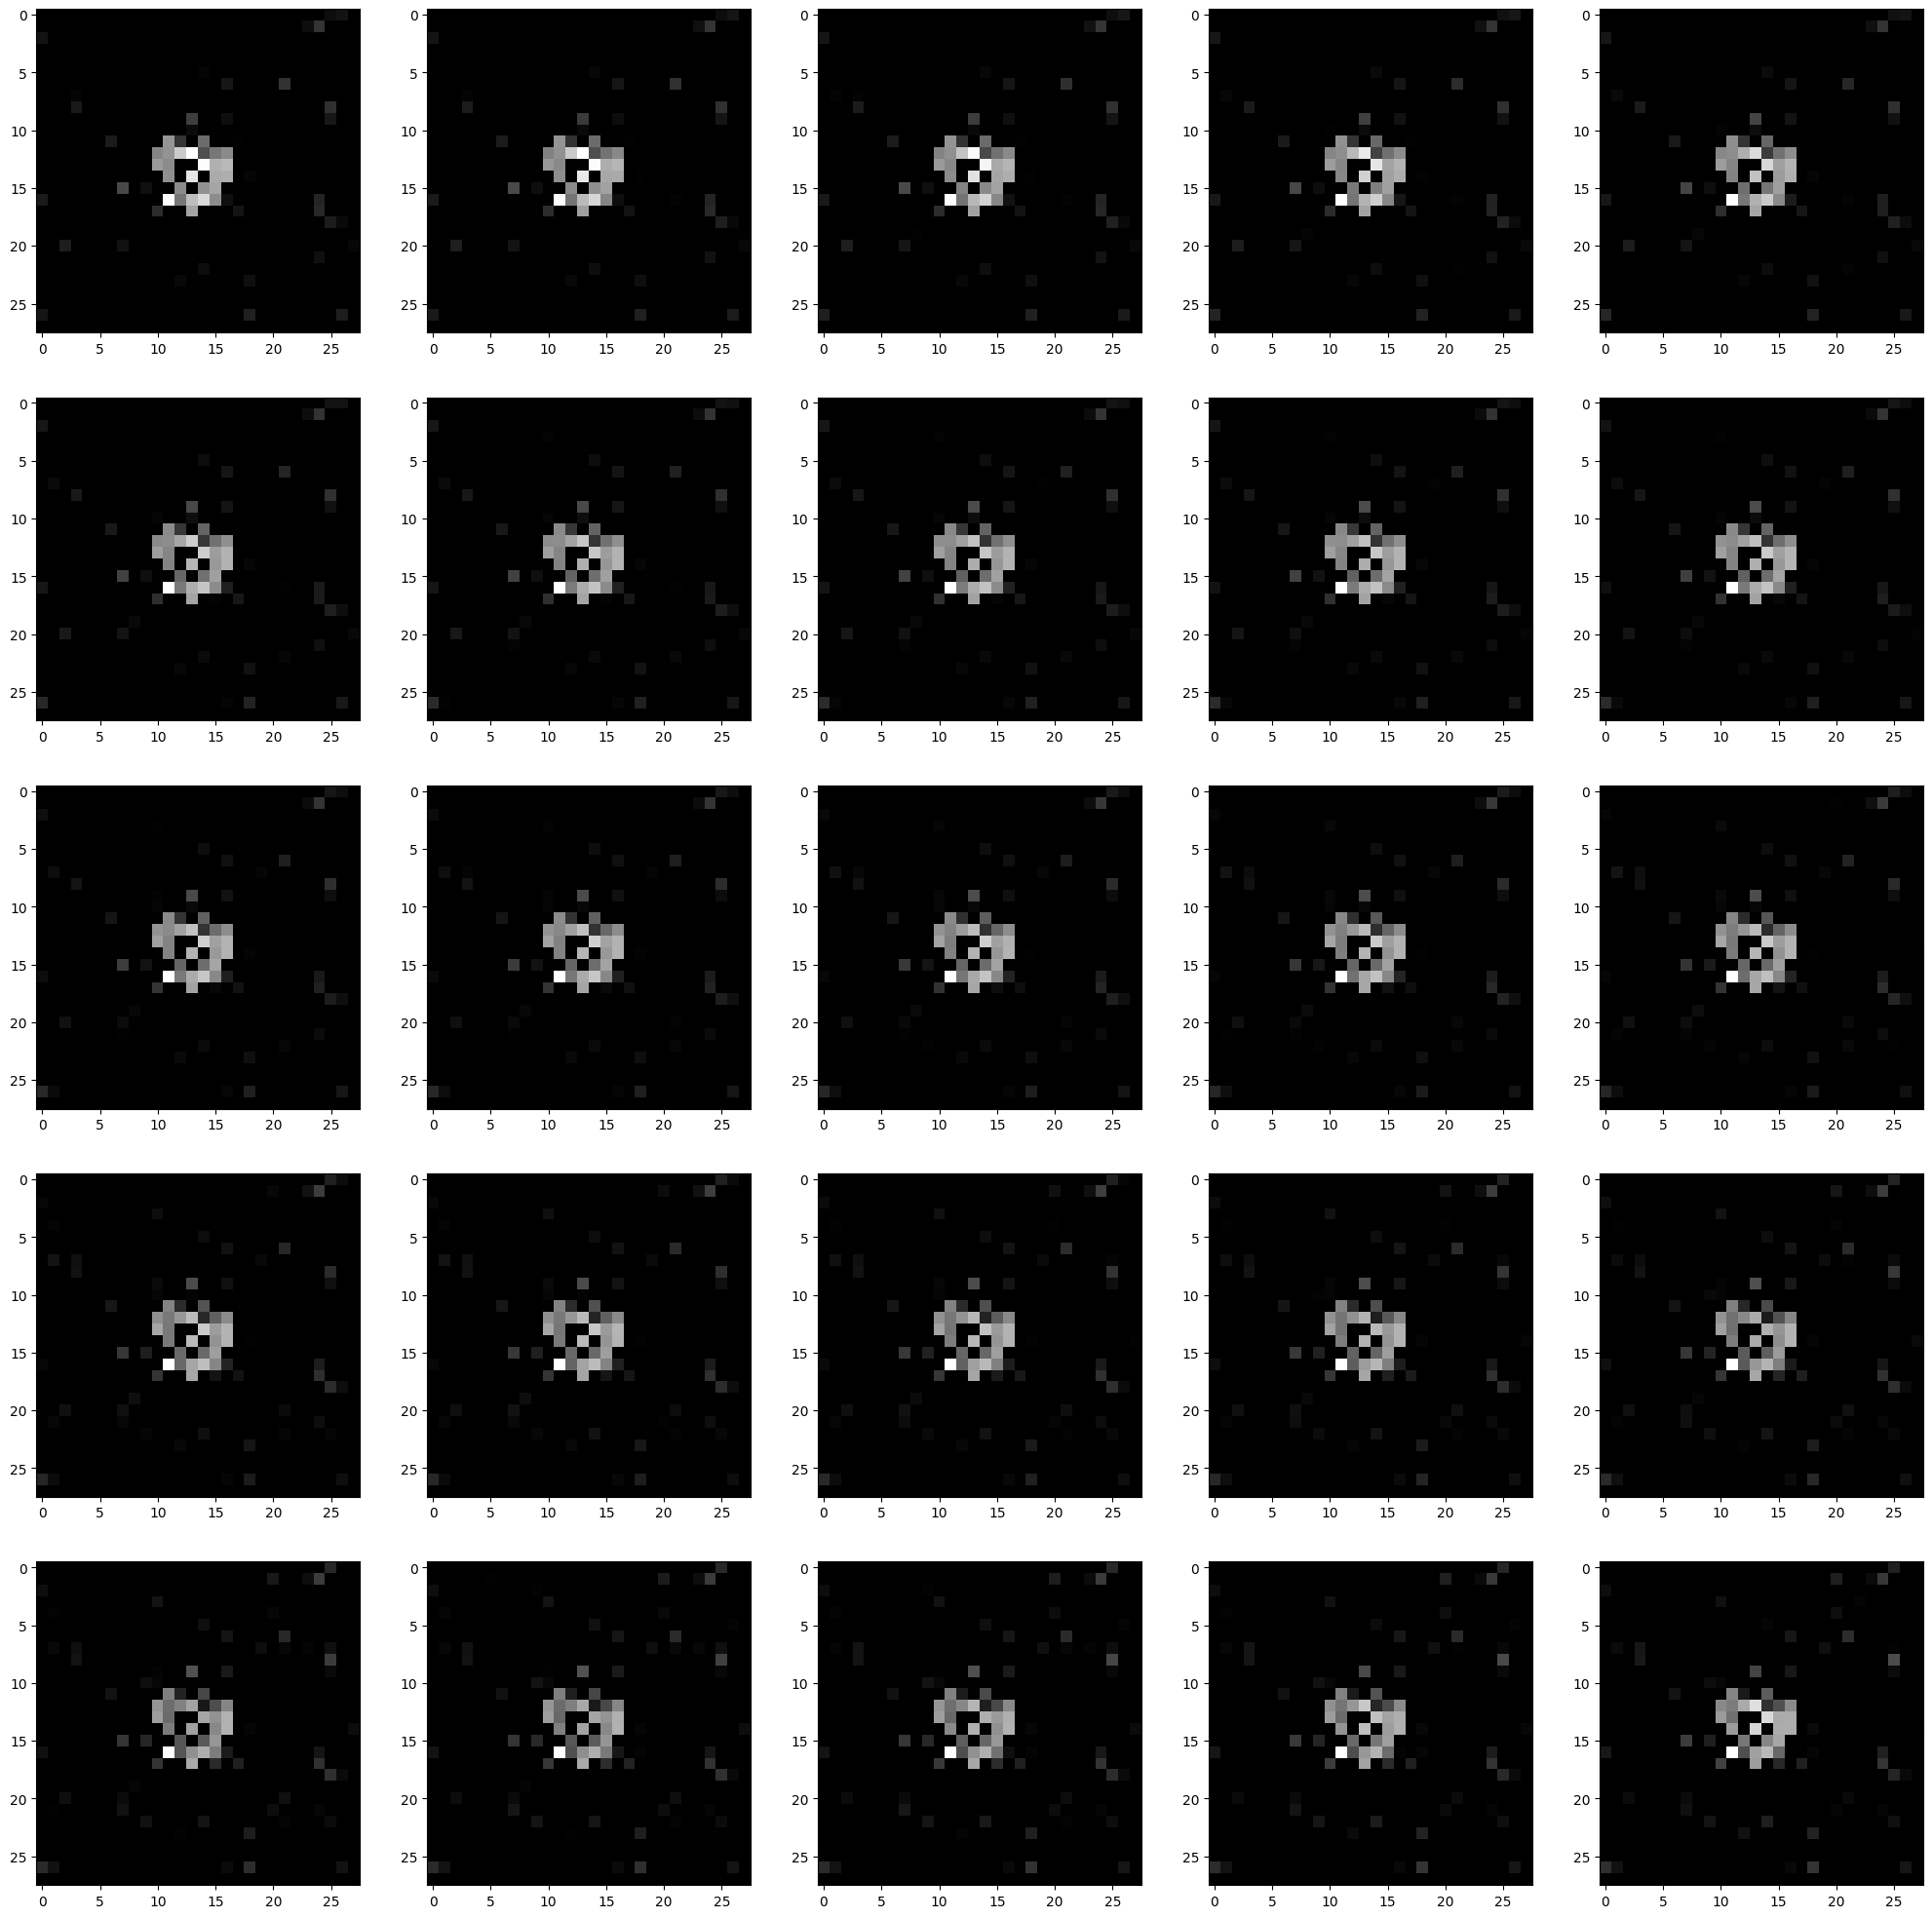

In [21]:
k = 0
plt.figure(figsize=(25,25))
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.imshow(reconstruction[k].numpy().reshape(i_height, i_width), cmap='gray')
  k+=1

plt.show()

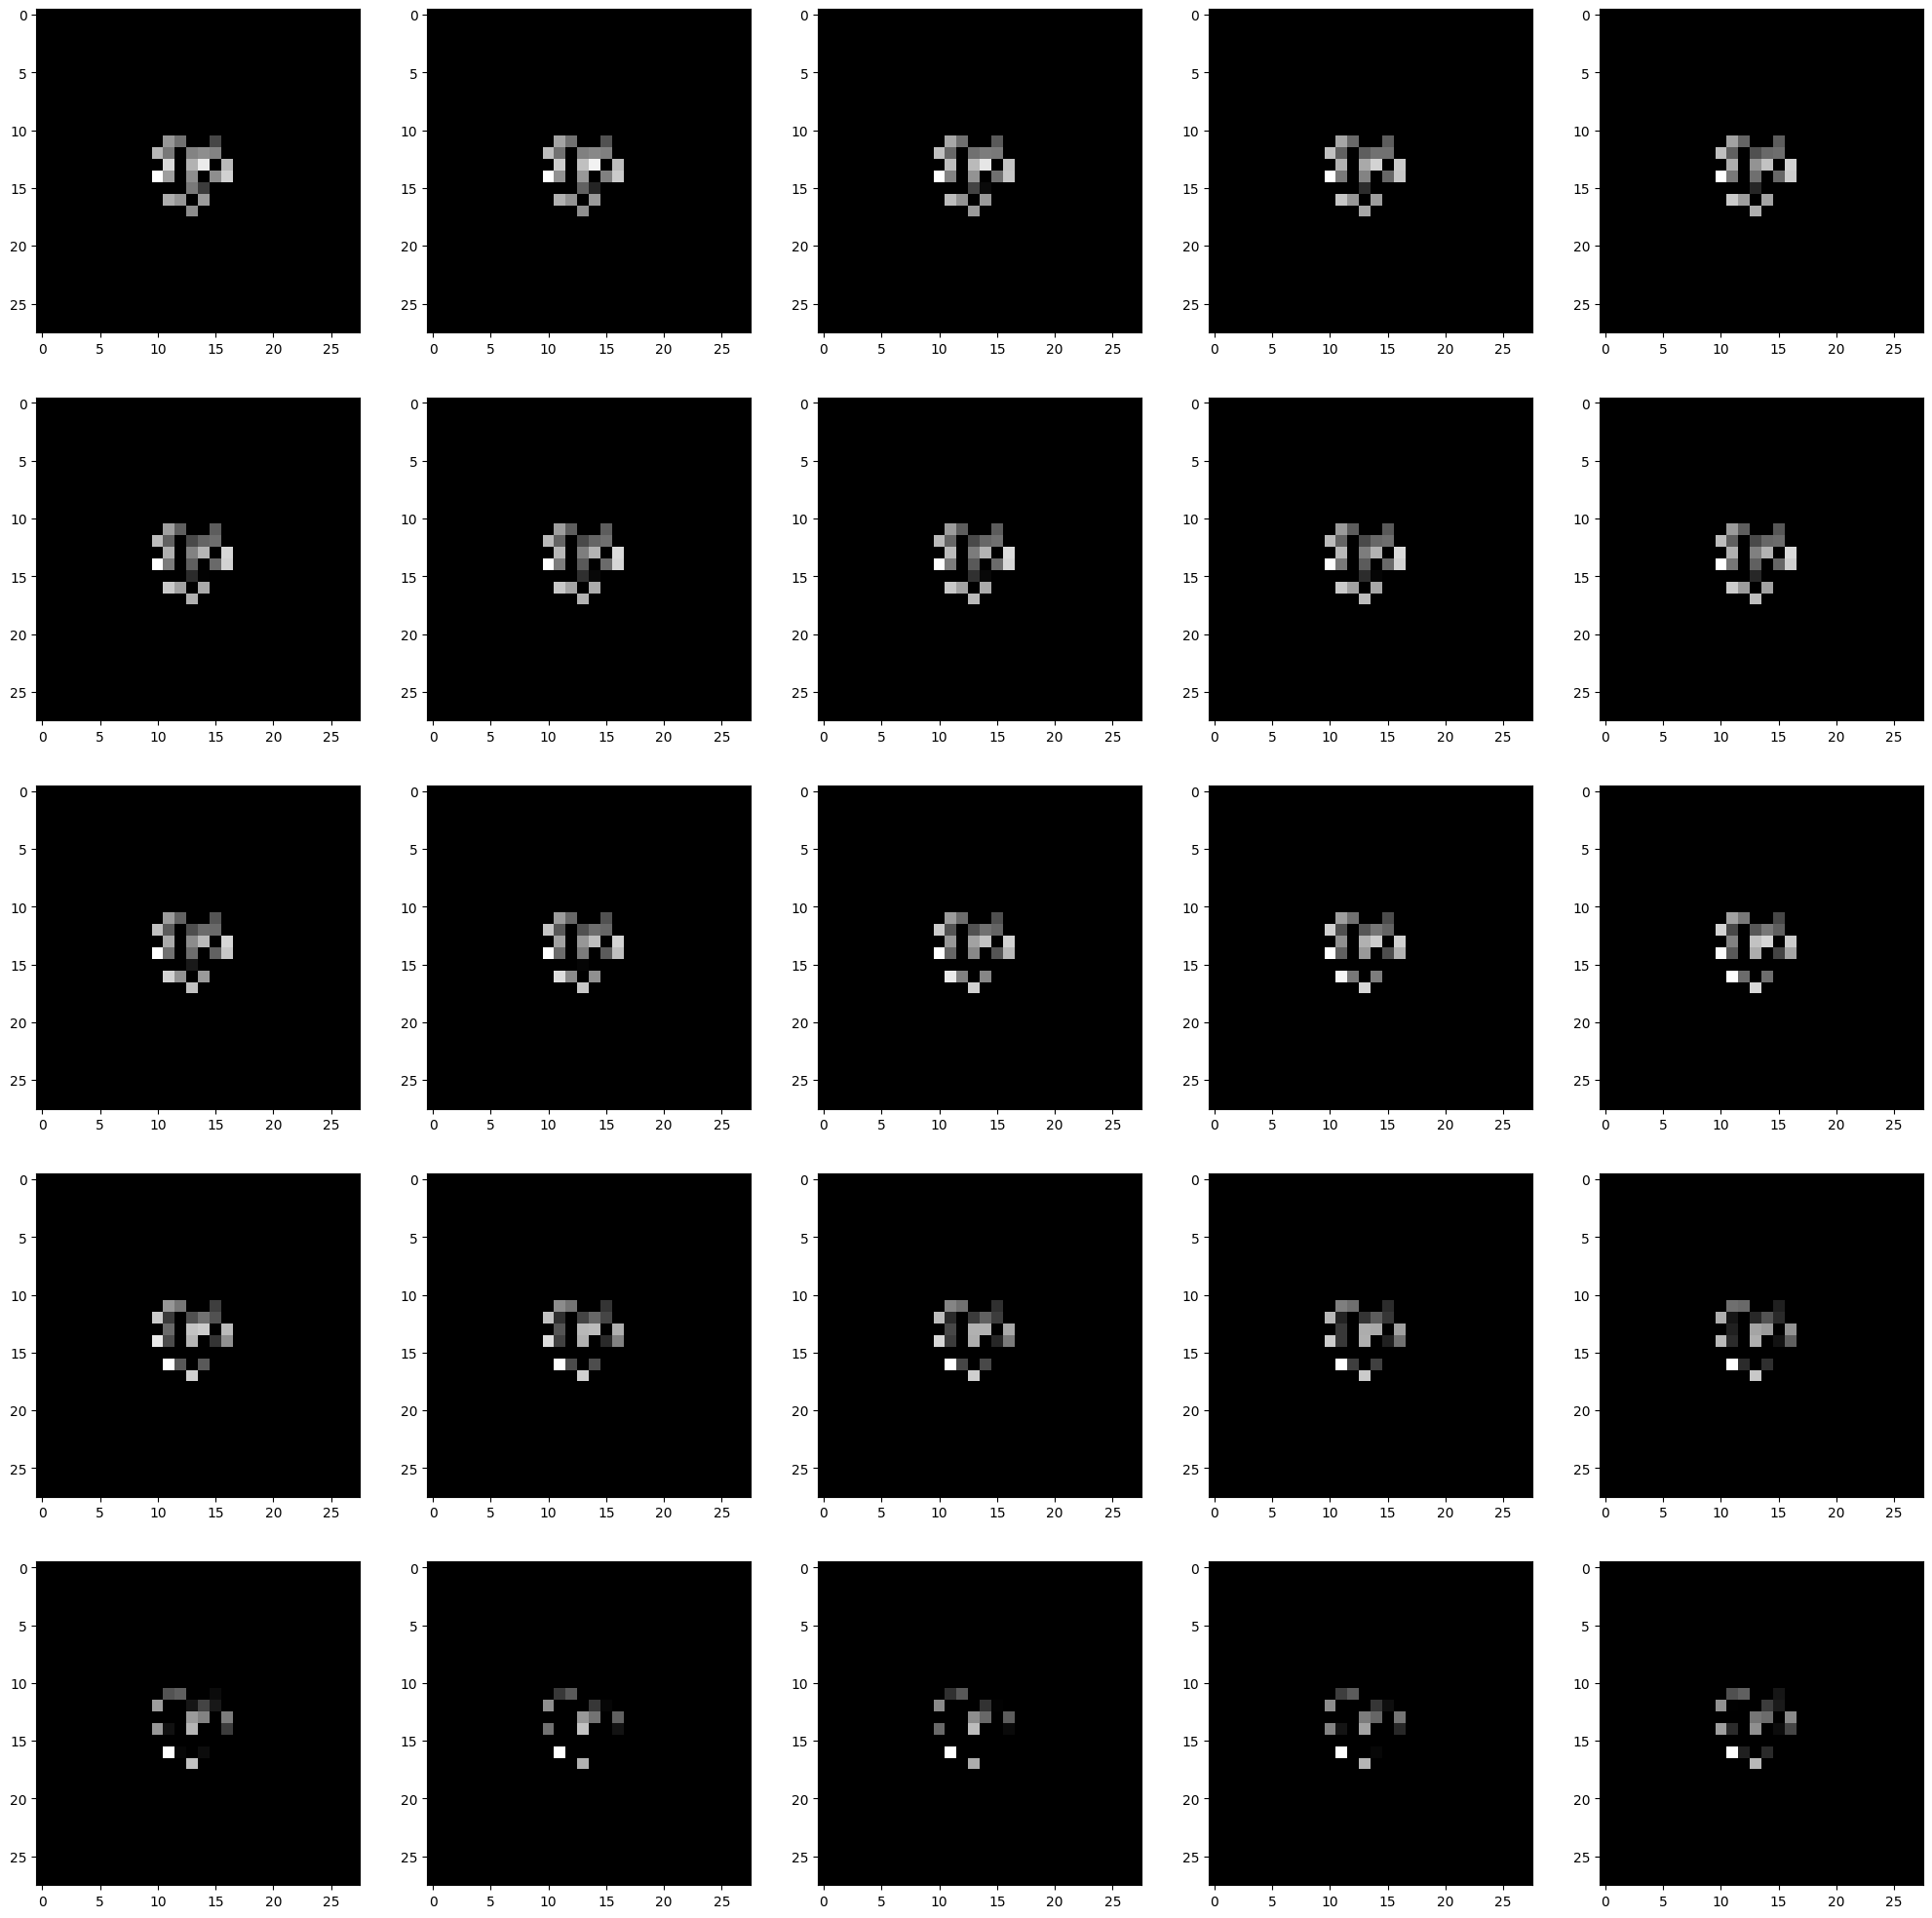

In [14]:
k = 0
plt.figure(figsize=(25,25))
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.imshow(reconstruction[k].numpy().reshape(i_height, i_width), cmap='gray')
  k+=1

plt.show()